In [2]:
import pandas as pd
import plotly.express as px
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff
import plotly.io as pio

import pickle
import joblib

import bz2file as bz2
import os

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn import metrics
from mlxtend.evaluate import bias_variance_decomp
from sklearn.model_selection import KFold, GridSearchCV

In [3]:
X_train = pd.read_csv('../data/processed/X_train.csv')
X_test = pd.read_csv('../data/processed/X_test.csv')

aux_y_train = pd.read_csv('../data/processed/y_train_e.csv')
aux_y_test = pd.read_csv('../data/processed/y_test_e.csv')

In [4]:
X_train.drop(columns=['Unnamed: 0'], axis = 1, inplace = True)
X_test.drop(columns=['Unnamed: 0'], axis = 1, inplace = True)

aux_y_train.drop(columns=['Unnamed: 0'], axis = 1, inplace = True)
aux_y_test.drop(columns=['Unnamed: 0'], axis = 1, inplace = True)

In [5]:
y_train = aux_y_train.squeeze()
y_test = aux_y_test.squeeze()

In [6]:
def check_bias_variance (m, X_train, y_train, X_test, y_test,  r):
    avg_expected_loss, avg_bias,avg_var  = bias_variance_decomp(m, 
                                                                X_train.to_numpy(),
                                                                y_train.to_numpy(), 
                                                                X_test.to_numpy(),
                                                                y_test.to_numpy(), 
                                                                loss='0-1_loss', 
                                                                num_rounds=r, 
                                                                random_seed=1)
    print('Bias Variance analisys')
    print('Average expected loss: %.3f' % avg_expected_loss)
    print('Average bias: %.3f' % avg_bias)
    print('Average variance: %.3f' % avg_var ) 

In [7]:
def evaluate_model(model, x_test, y_test):
    
    y_pred = model.predict(x_test)
    
    f1 = metrics.f1_score(y_test, y_pred, average='weighted')
    Precision =  metrics.precision_score(y_test, y_pred, average= 'weighted')
    Recall    =  metrics.recall_score(y_test, y_pred, average= 'weighted')
    Accuracy  =  metrics.accuracy_score(y_test, y_pred)
    cm = metrics.confusion_matrix(y_test, y_pred)
    return {'f1': f1,
            'cm': cm,
            'Precision': Precision, 
            'Recall' : Recall,
            'Accuracy' :  Accuracy
           }

In [8]:
def generate_model(model, X_train, X_test, y_train, y_test ):
    
    if model == 'RandomForestClassifier':
        rf = RandomForestClassifier(random_state=0)
        rf.fit(X_train, y_train)
        rf_eval = evaluate_model(rf, X_test, y_test)
        print('RandomForestClassifier - F1 Score:', rf_eval['f1'])
        print('RandomForestClassifier - CM:', rf_eval['cm'])
        check_bias_variance (rf, X_train, y_train, X_test, y_test,  5)
    if model == 'GaussianNB':
            nb = GaussianNB()
            nb.fit(X_train, y_train)            
            nb_eval = evaluate_model(nb, X_test, y_test)
            # Print result
            print('GaussianNB - F1 Score:', nb_eval['f1'])
            check_bias_variance (nb, X_train, y_train, X_test, y_test,  5)
    if model == 'KNeighborsClassifier':
            knn = KNeighborsClassifier()
            knn.fit(X_train, y_train)            
            knn_eval = evaluate_model(knn, X_test, y_test)
            # Print result
            print('KNeighborsClassifier - F1 Score:', knn_eval['f1'])
            check_bias_variance (knn, X_train, y_train, X_test, y_test,  5)
    if model == 'DecisionTreeClassifier':
            dtc = tree.DecisionTreeClassifier(random_state=0)
            dtc.fit(X_train, y_train)            
            # Evaluate Model
            dtc_eval = evaluate_model(dtc, X_test, y_test)
            # Print result
            print('DecisionTreeClassifier - F1 Score:', dtc_eval['f1'])
            check_bias_variance (dtc, X_train, y_train, X_test, y_test,  5)            
    if model == 'xtree':
            xt = ExtraTreesClassifier(random_state = 1)
            xt.fit(X_train, y_train)            
            # Evaluate Model
            dtc_eval = evaluate_model(xt, X_test, y_test)
            # Print result
            print('xtree - F1 Score:', dtc_eval['f1'])
            print('xtree - Precision:', dtc_eval['Precision'])
            print('xtree - Recall:', dtc_eval['Recall'])            
            print('xtree - Accuracy:', dtc_eval['Accuracy'])            
            print('xtree - CM:')
            print(dtc_eval['cm'])
            check_bias_variance (xt, X_train, y_train, X_test, y_test,  5)  

In [8]:
# generate_model('RandomForestClassifier', X_train, X_test, y_train, y_test)

In [9]:
# generate_model('GaussianNB', X_train, X_test, y_train, y_test)

In [10]:
# generate_model('KNeighborsClassifier', X_train, X_test, y_train, y_test)

In [11]:
# generate_model('DecisionTreeClassifier', X_train, X_test, y_train, y_test)

In [12]:
generate_model('xtree', X_train, X_test, y_train, y_test)

xtree - F1 Score: 0.7741548827501595
xtree - Precision: 0.7633530886190142
xtree - Recall: 0.8129905277401894
xtree - Accuracy: 0.8129905277401894
xtree - CM:
[[   3    6   43]
 [   0   60  492]
 [   0  150 2941]]
Bias Variance analisys
Average expected loss: 0.201
Average bias: 0.198
Average variance: 0.035


In [13]:
# xtree - F1 Score: 0.8121786197564276
# xtree - CM: [[   2    3   47]
#  [   0   60  492]
#  [   0  152 2939]]
# Bias Variance analisys
# Average expected loss: 0.236
# Average bias: 0.212
# Average variance: 0.024


In [9]:
gkf2 = KFold(n_splits=3, shuffle=True, random_state=101).split(X=X_train, y=y_train)

params2 = {
    'max_depth': [11,15],
    'min_samples_split': [2,3],
    'class_weight': ['balanced', None],
    'n_estimators' : [100,200,300,400]
}

extree2 = ExtraTreesClassifier(random_state = 1, 
                               ccp_alpha = 0.0,
                               criterion = 'gini',
                               max_depth = 11,
                               min_samples_split = 3)

gsearch2 = GridSearchCV(
    estimator= extree2,
    param_grid= params2,
    scoring='f1_weighted',
    n_jobs=-1,
    cv=gkf2,
    verbose=3,
)

extree_model2 = gsearch2.fit(X=X_train, y=y_train)

(gsearch2.best_params_, gsearch2.best_score_)

Fitting 3 folds for each of 32 candidates, totalling 96 fits


({'class_weight': 'balanced',
  'max_depth': 15,
  'min_samples_split': 2,
  'n_estimators': 400},
 0.9241085818969735)

In [10]:
extree_tuned = ExtraTreesClassifier(random_state = 1,
                                    ccp_alpha = 0.0,
                                    criterion = 'gini',
                                    min_samples_split = 2,
                                    class_weight = 'balanced',
                                    max_depth = 15,
                                    n_estimators = 200)

extree_tuned.fit(X_train, y_train)

ExtraTreesClassifier(class_weight='balanced', max_depth=15, n_estimators=200,
                     random_state=1)

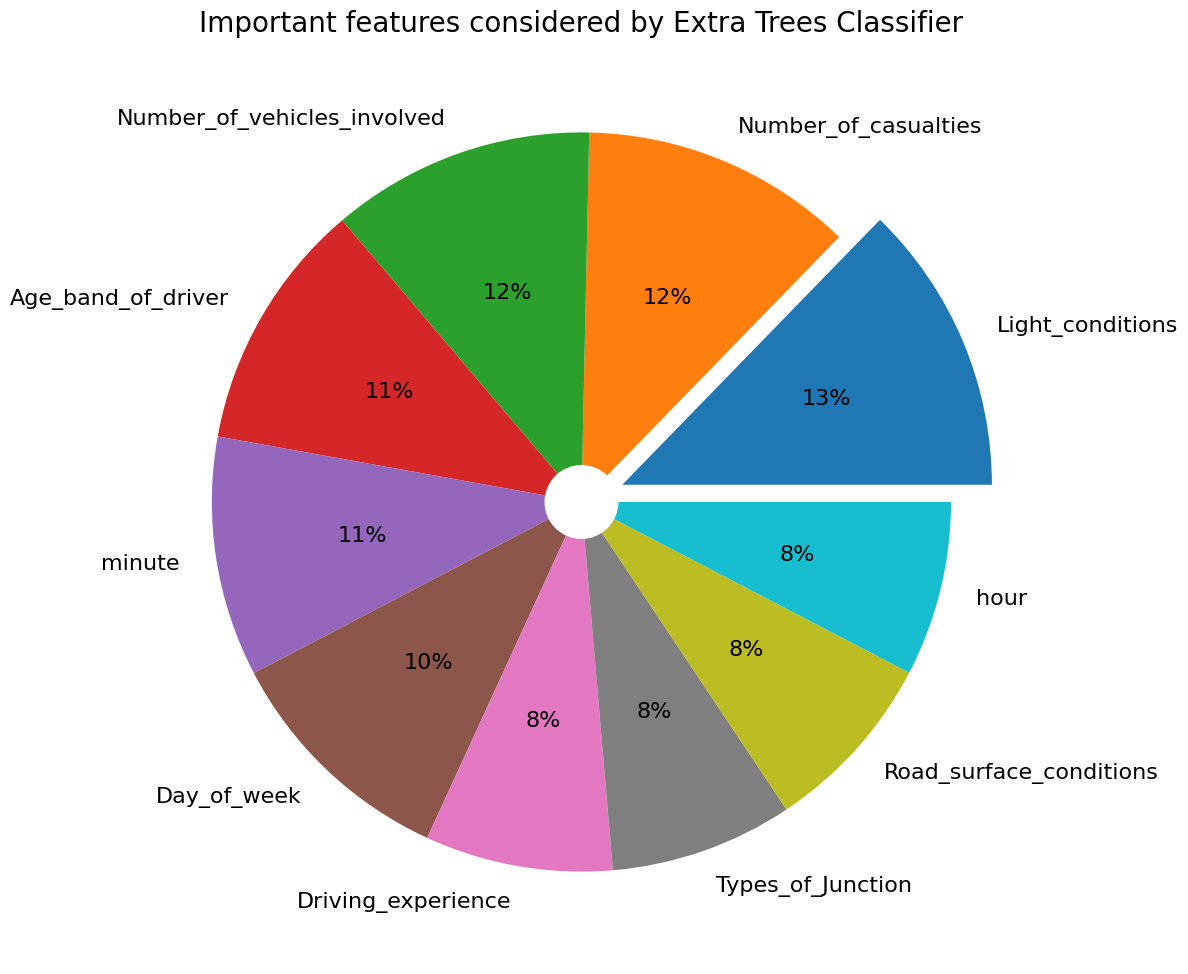

In [11]:
import matplotlib.pyplot as plt
feat_importances = pd.Series(extree_tuned.feature_importances_, index=X_train.columns)
plt.figure(figsize=(12,12))
myexplode = [0.12,0,0,0,0,0,0,0,0,0]
plt.pie(feat_importances.nlargest(10),labels=feat_importances.nlargest(10).index, autopct='%.0f%%',explode= myexplode,
        textprops={'fontsize': 16})
centre_circle = plt.Circle((0,0),0.10,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title('Important features considered by Extra Trees Classifier',fontsize=20)
plt.show()

In [12]:
pickle.dump(extree_tuned, open('../models/TrafficSeverityClassificationModel2.pkl', 'wb'))

In [13]:
joblib.dump(extree_tuned, '../models/TrafficSeverityClassificationModel2.joblib', compress=3)

['../models/TrafficSeverityClassificationModel2.joblib']

In [19]:
# model = joblib.load(r'../models/TrafficSeverityClassificationModel2.pkl')

In [20]:
# with bz2.BZ2File('../models/TrafficSeverityClassificationModel2.pbz2','w') as f:
#     pickle.dump(model, f)    